In [3]:
%cd ..
!pwd

/home/jasper/Documents/PhD/Y0/vae_sketch_to_sound
/home/jasper/Documents/PhD/Y0/vae_sketch_to_sound


In [4]:
from benchmark_VAE.src.pythae.models import VQVAE, VQVAEConfig
from benchmark_VAE.src.pythae.models import SVAE, SVAEConfig
from benchmark_VAE.src.pythae.trainers import BaseTrainerConfig
from benchmark_VAE.src.pythae.pipelines.training import TrainingPipeline
from benchmark_VAE.src.pythae.models.nn.benchmarks.mnist.resnets import Encoder_ResNet_VQVAE_MNIST, Decoder_ResNet_VQVAE_MNIST

from benchmark_VAE.src.pythae.models.nn.benchmarks.celeba2.resnets import Encoder_ResNet_SVAE_CELEBA, Decoder_ResNet_AE_CELEBA


import torch
import torchvision.datasets as datasets

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

/home/jasper/miniforge3/envs/s2s/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [5]:
from torchvision.transforms.functional import to_pil_image

In [4]:

model_config = VQVAEConfig(
    latent_dim=64,
    input_dim=(1, 112, 112),
    commitment_loss_factor=0.25,
    quantization_loss_factor=1.0,
    num_embeddings=256,
    use_ema=True,
    decay=0.99
)

model = VQVAE(
    model_config=model_config,
    encoder=Encoder_ResNet_VQVAE_MNIST(model_config), 
    decoder=Decoder_ResNet_VQVAE_MNIST(model_config) 
).to(device)

In [5]:
model

VQVAE(
  (decoder): Decoder_ResNet_VQVAE_MNIST(
    (layers): ModuleList(
      (0): ConvTranspose2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Sequential(
        (0): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(256, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(32, 256, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (1): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(256, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(32, 256, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (2): ReLU()
      )
      (3): Sequential(
        (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        (1): ReLU(

In [10]:
mnist_trainset = datasets.MNIST(root='../../data', train=True, download=True, transform=None)

train_dataset = mnist_trainset.data[:-50000].reshape(-1, 1, 28, 28) / 255.
eval_dataset = mnist_trainset.data[-10000:].reshape(-1, 1, 28, 28) / 255.

In [7]:
train_dataset[:1].shape

torch.Size([1, 1, 28, 28])

In [49]:
embedding = model.encoder(train_dataset[:1]).embedding
embedding.shape

torch.Size([1, 16, 4, 4])

In [50]:
embeddings = embedding.permute(0, 2, 3, 1)
embeddings.shape

torch.Size([1, 4, 4, 16])

In [53]:
z = model.quantizer(embeddings, uses_ddp=False).quantized_vector

In [20]:
img = torch.nn.functional.interpolate(train_dataset[2:5], size=(64,64))
img.shape

torch.Size([3, 1, 64, 64])

In [7]:
from PIL import Image
import numpy as np

torch.Size([1, 1, 112, 112])


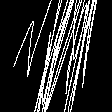

In [8]:
img = np.array(Image.open('./datasets/crop_640/1/00000_614a_d239.png'))
img = torch.from_numpy(img).to(device)
img = 1-img.unsqueeze(0).unsqueeze(0)/255.

img = torch.nn.functional.interpolate(img, size=(112,112))
print(img.shape)
to_pil_image(img[0])

In [8]:
img.max()

tensor(1., device='cuda:0')

In [12]:
%%time
out = model(dict(data=img))

CPU times: user 2.61 ms, sys: 0 ns, total: 2.61 ms
Wall time: 2.16 ms


In [13]:
out.keys()

odict_keys(['recon_loss', 'vq_loss', 'loss', 'recon_x', 'z', 'quantized_indices'])

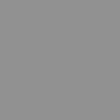

In [14]:
to_pil_image(out.recon_x[0])

In [15]:
model.encoder

Encoder_ResNet_VQVAE_MNIST(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (3): Sequential(
      (0): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (4): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (5): Sequential(
      (0): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (1): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1,

## Training

In [5]:
!pwd

/home/jasper/Documents/PhD/Y0/vae_sketch_to_sound


In [6]:
my_training_config = BaseTrainerConfig(
    output_dir='/home/jasper/Documents/PhD/Y0/vae_sketch_to_sound/out',
    num_epochs=10000,
    learning_rate=1e-4,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    # train_dataloader_num_workers=2,
    # eval_dataloader_num_workers=2,
    steps_saving=2000,
    # optimizer_cls="AdamW",
    # optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
    # scheduler_cls="ReduceLROnPlateau",
    # scheduler_params={"patience": 5, "factor": 0.5}
)

pipeline = TrainingPipeline(
    training_config=my_training_config,
	model=model
)

In [7]:
from PIL import Image
import os, os.path
import numpy as np

In [8]:
# _Read Images to Array from Folder

imgs = []
labels = []

path = "/home/jasper/Documents/PhD/Y0/vae_sketch_to_sound/datasets/crop_640/1"
path = os.path.join(path,'')

size = 112

valid_images = [".jpg",".gif",".png",".tga"]

for i,f in enumerate(os.listdir(path)):
  ext = os.path.splitext(f)[1]
  filename = os.path.splitext(f)[0]
  if ext.lower() not in valid_images:
      continue
  imgs.append(np.array(Image.open(os.path.join(path,f)).resize((size,size))))
  # labels.append(int(filename[-2]))

  if i%500==0:
    print(f'processing index {i}')

img_data_x = np.array(imgs)
img_data_y = np.array(labels)
np.random.shuffle(img_data_x)
print(f'collected data {img_data_x.shape}\ncollected label {img_data_y.shape}')

processing index 0
processing index 500
processing index 1000
processing index 1500
processing index 2000
collected data (2217, 112, 112)
collected label (0,)


In [9]:
img_data_x = torch.from_numpy(img_data_x).to(device)

img_data_x = 1-img_data_x/255.
img_data_x = img_data_x.unsqueeze(1)
# img_data_x = img_data_x.permute(0,3,1,2)

print(img_data_x.shape)
print(img_data_x.max())
print(img_data_x.min())

torch.Size([2217, 1, 112, 112])
tensor(1., device='cuda:0')
tensor(0., device='cuda:0')


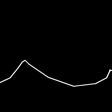

In [10]:
to_pil_image(img_data_x[10])

In [ ]:
pipeline(
    train_data=img_data_x,
    eval_data=None
)

Preprocessing train data...
Checking train dataset...
Using Base Trainer

! No eval dataset provided ! -> keeping best model on train.

Model passed sanity check !
Ready for training.

Created /home/jasper/Documents/PhD/Y0/vae_sketch_to_sound/out/VQVAE_training_2023-10-24_09-55-50. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 10000
 - per_device_train_batch_size: 64
 - per_device_eval_batch_size: 64
 - checkpoint saving every: 2000
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Scheduler: None

Successfully launched training !

Training of epoch 1/10000: 100%|█████████████████████████| 35/35 [00:01<00:00, 31.48batch/s]
--------------------------------------------------------------------------
Train loss: 146.8693
-------------------------------------

In [16]:
%%time
reconstructions = model.reconstruct(img_data_x[:6].to(device)).detach().cpu()

CPU times: user 30.7 ms, sys: 0 ns, total: 30.7 ms
Wall time: 28.7 ms


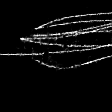

In [23]:
to_pil_image(reconstructions[5])

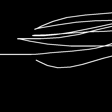

In [24]:
to_pil_image(img_data_x[5])

In [33]:
img_data_x.max()

tensor(1., device='cuda:0')

In [34]:
reconstructions.max()

tensor(4.6299e-33)

In [3]:
%cd ..

/home/jasper/Documents/PhD/Y0/vae_sketch_to_sound


In [4]:
!rm -r out

## Load

In [9]:
import os
from benchmark_VAE.src.pythae.models import AutoModel

In [18]:
# last_training = sorted(os.listdir('./out/VQVAE_training_2023-10-23_21-16-23/'))[-1]
trained_model = AutoModel.load_from_folder(os.path.join('./out/VQVAE_training_2023-10-24_00-02-38/', 'final_model')).to(device)

torch.Size([1, 1, 112, 112])


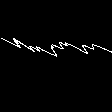

In [15]:
img = np.array(Image.open('./datasets/crop_640/1/00011_614a_416c.png'))
img = torch.from_numpy(img).to(device)
img = 1-img.unsqueeze(0).unsqueeze(0)/255.

img = torch.nn.functional.interpolate(img, size=(112,112))
print(img.shape)
to_pil_image(img[0])

In [19]:
reconstructions = trained_model.reconstruct(img.to(device)).detach().cpu()

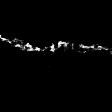

In [17]:
to_pil_image(reconstructions[0])

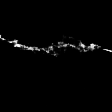

In [20]:
to_pil_image(reconstructions[0])

In [16]:
!pwd

/home/jasper/Documents/PhD/Y0/vae_sketch_to_sound


In [24]:
model

VQVAE(
  (decoder): Decoder_ResNet_VQVAE_CELEBA(
    (layers): ModuleList(
      (0): ConvTranspose2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
      (1): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Sequential(
        (0): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (1): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
      )
      (3): Sequential(
        (0): ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
      )
      (4): Sequential(
        (0): ConvTranspose2d(